# Compare Gridded Precipitation Datasets

In this lesson, we will use data obtained in previous lessons. 

1. Gridded GFS precipication forecast data, aggregated to daily precipiation totals.
2. Bias-corrected GFS precipitation forecast data.

### Import libraries

In [33]:
# Find the directory of the current project and add to PATH
import sys, os, arcpy
from glob import glob

# The 00_environment_setup notebook contains libraries and other things common to all the notebooks (e.g. file paths)
%run "00_environment_setup.ipynb"

# Additional libraries needed for this script
%matplotlib notebook

Active Portal in ArcGIS Pro
Logged in as ksampson
Current conda environment:
	arcgispro-py3-clone C:\Users\ksampson\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone
Found input data directory: C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\input
Completed importing and/or installing libraries in 4.73 seconds.


### Set Precipitation color-maps

In [34]:
cmap = matplotlib.colormaps['gist_ncar']  # Color ramp suitable for precipiation
cmap.set_under('lightgrey')               # Set values of zero precipitation to grey

### Define input datasets

This exercise requires data that was computed during previous exercises.

In [35]:
# Basin polygon for peforming spatial aggregation
basin = os.path.join(input_data_dir, 'basins', 'KRS_Basins.shp')

In [36]:
# Find the dataset either by name or using a wildcard string and the glob function
GFS_daily = glob(os.path.join(output_data_dir, 'gfs_0p25_1hr_*_daily.nc'))[-1]
print('Found daily GFS file:\n\t{0}'.format(GFS_daily))

Found daily GFS file:
	C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\output\gfs_0p25_1hr_00z_gfs20231025_daily.nc


In [37]:
# Find the dataset either by name or using a wildcard string and the glob function
GFS_Bias_Corrected = glob(os.path.join(output_data_dir, 'realtime_sample_data', '**/*.nc'), recursive = True)[0]
print('Found bias-corrected daily GFS file:\n\t{0}'.format(GFS_Bias_Corrected))

Found bias-corrected daily GFS file:
	C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\output\realtime_sample_data\gfs\q2q_corrected\gfs_india_0p25deg_24hr_2023102500.nc


### Open the datasets using xarray

In [38]:
GFS_input_ds = xr.open_dataset(GFS_daily)
GFS_input_ds

<xarray.Dataset>
Dimensions:  (time: 10, lat: 129, lon: 135)
Coordinates:
  * time     (time) datetime64[ns] 2023-10-25 2023-10-26 ... 2023-11-03
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    pr       (time, lat, lon) float32 ...

Plot the GFS forecast for the first time-step

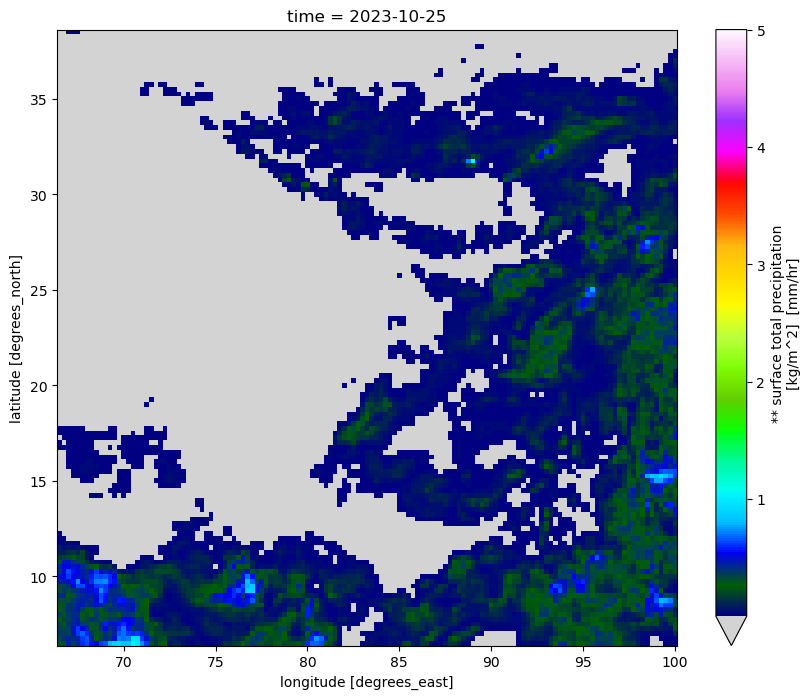

In [39]:
%matplotlib inline            
GFS_input_ds['pr'].isel({'time':0}).plot(figsize=(10,8), cmap=cmap,vmin=0.001,vmax=5)

In [40]:
GFS_corrected_ds = xr.open_dataset(GFS_Bias_Corrected)
GFS_corrected_ds = GFS_corrected_ds.rename({'Precipitation':'pr_corrected', 'forecast_time': 'time'})
GFS_corrected_ds

<xarray.Dataset>
Dimensions:       (time: 10, lat: 129, lon: 135)
Coordinates:
  * lat           (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * lon           (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * time          (time) datetime64[ns] 2023-10-25 2023-10-26 ... 2023-11-03
Data variables:
    pr_corrected  (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.7
    title:        Forecast model run with bias correction
    source:       gfs
    history:      2023-10-27 05:23:13.596384 Python
    comment:      This file has been bias corrected using C:\Users\ksampson\D...

Plot the bias-corrected GFS forecast for the first time-step

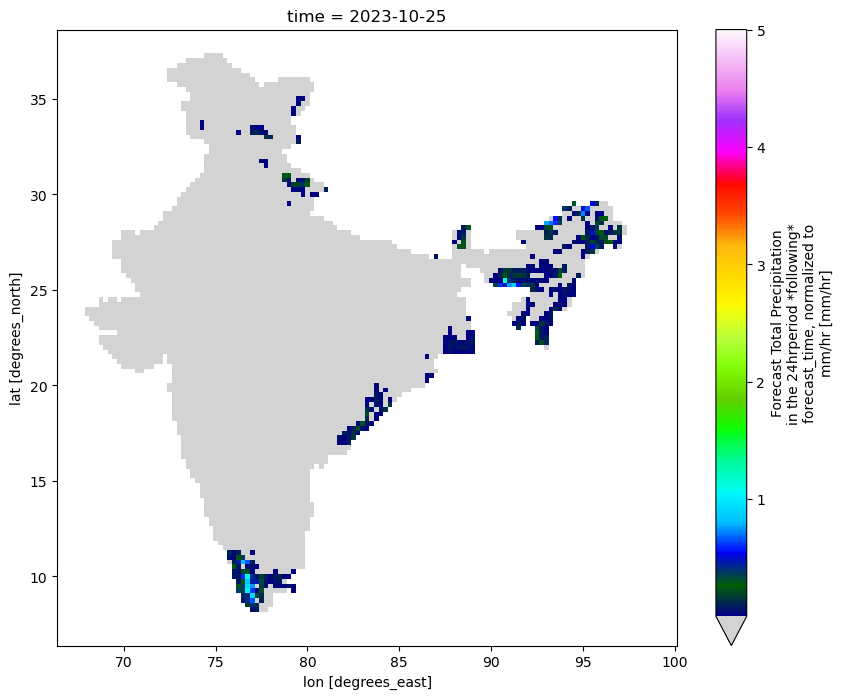

In [41]:
%matplotlib inline
GFS_corrected_ds['pr_corrected'].isel({'time':0}).plot(figsize=(10,8), cmap=cmap,vmin=0.001,vmax=5)

### Construct a valid-data mask so we do not compare NoData cells

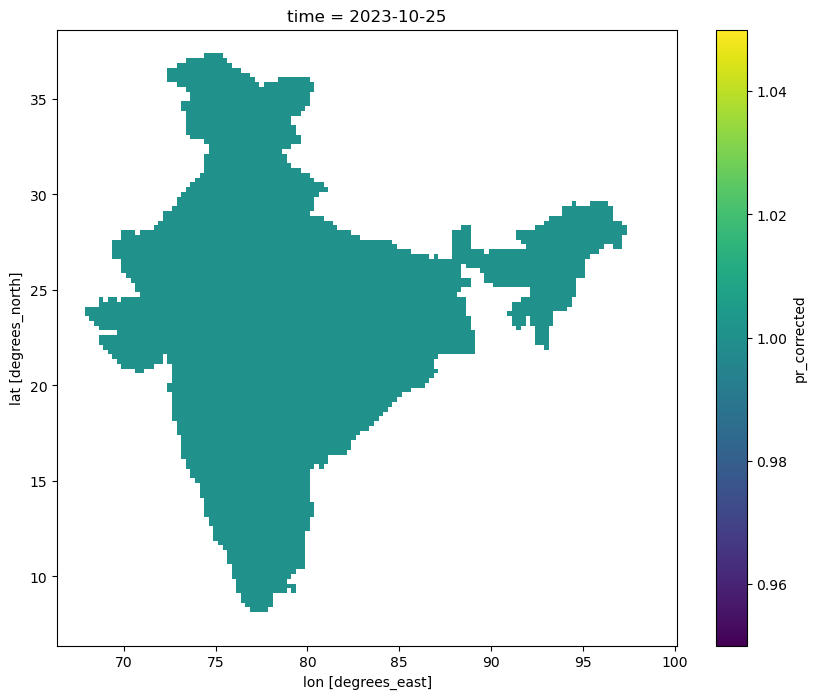

In [42]:
india_mask = (GFS_corrected_ds['pr_corrected'][0,:,:]+1)/(GFS_corrected_ds['pr_corrected'][0,:,:]+1)
india_mask.plot(figsize=(10,8))

Apply the mask to the GFS forecast data

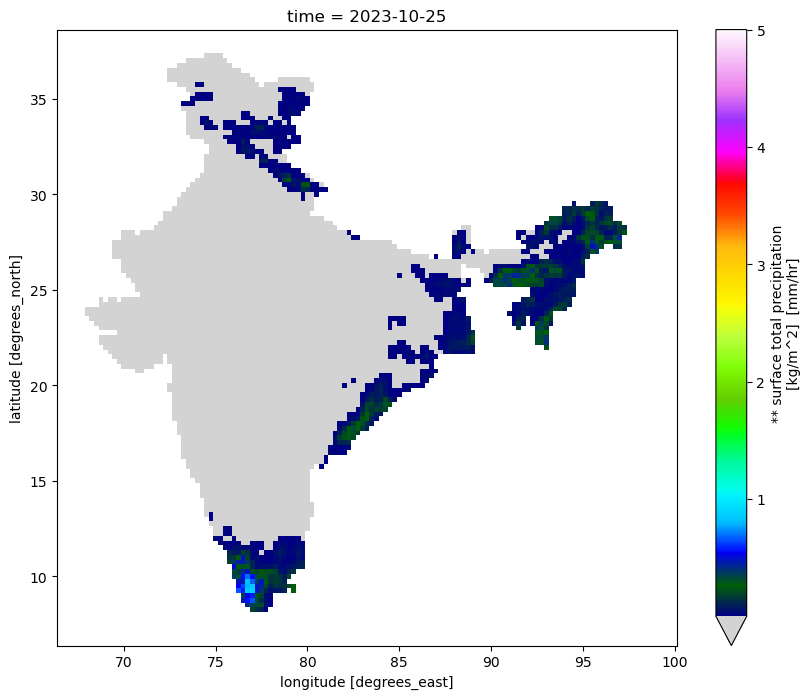

In [43]:
%matplotlib inline    
GFS_input_ds['pr']*=india_mask        
GFS_input_ds['pr'].isel({'time':0}).plot(figsize=(10,8), cmap=cmap,vmin=0.001,vmax=5)

### Extract a time-series from a single point within the GFS domains

We will select one grid-cell from within the model subset domain and plot the data for that cell over time. 

Again, `xarray` will know how to plot the data based on the number of dimensions (in this case just `time`), and plot the data with a line, labeling the axes with the coordinate values.

Extracting point time-series for point with (longitude,latitude) = ((76.586, 12.43))


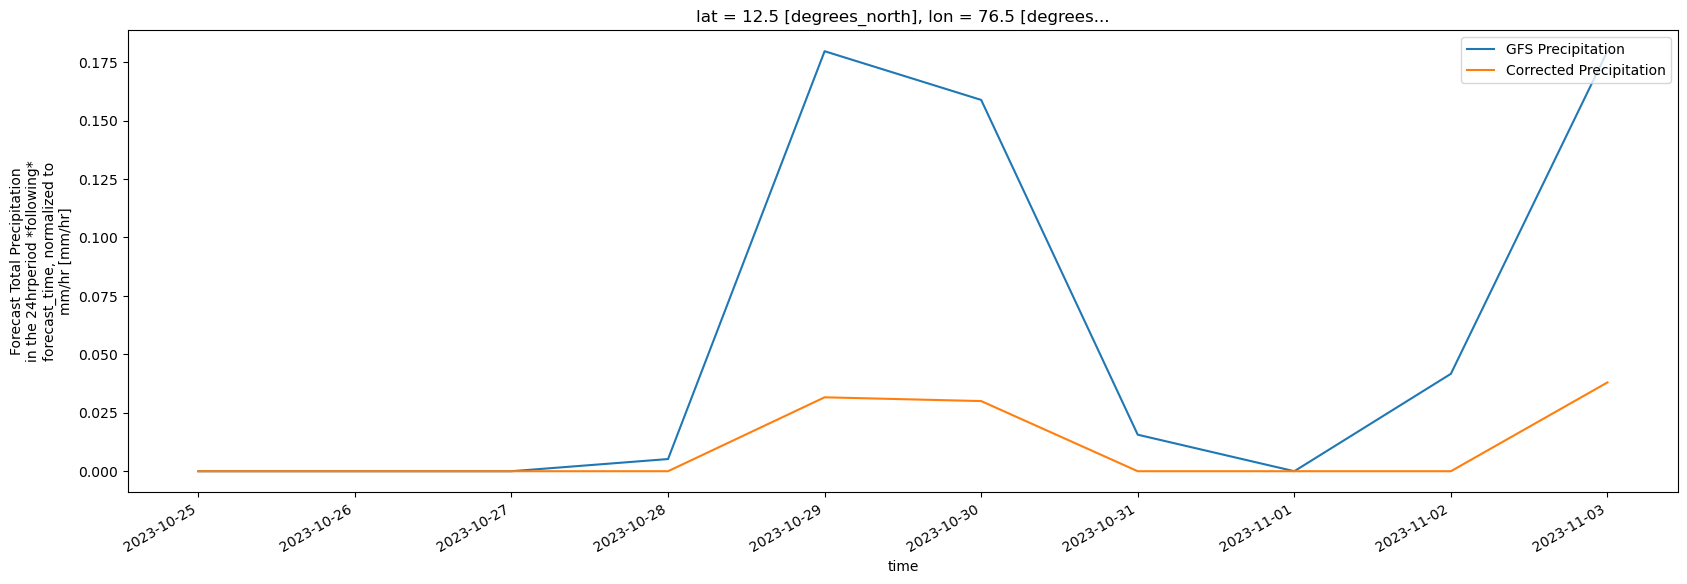

In [46]:
%matplotlib inline

# Select a location in the model's x,y coordinate system.
point_lon_lat = (76.586, 12.43)    # KRS Dam
#point_lon_lat = (71.25, 27.75)      # More interesting location in test_data
print(f'Extracting point time-series for point with (longitude,latitude) = ({point_lon_lat})')

# Use nearest neighbor method to extract the grid cell closest to the desired point
ds_point_1 = GFS_input_ds.sel(lat=point_lon_lat[1], lon=point_lon_lat[0], method="nearest")
ds_point_2 = GFS_corrected_ds.sel(lat=point_lon_lat[1], lon=point_lon_lat[0], method="nearest")

# Plot the time-series
fig, ax = plt.subplots(figsize=(20,6)) 
ds_point_1['pr'].plot(ax=ax, label='GFS Precipitation')
ds_point_2['pr_corrected'].plot(ax=ax, label='Corrected Precipitation')
ax.legend(loc=1) 

### Plot GFS against Bias-Corrected GFS

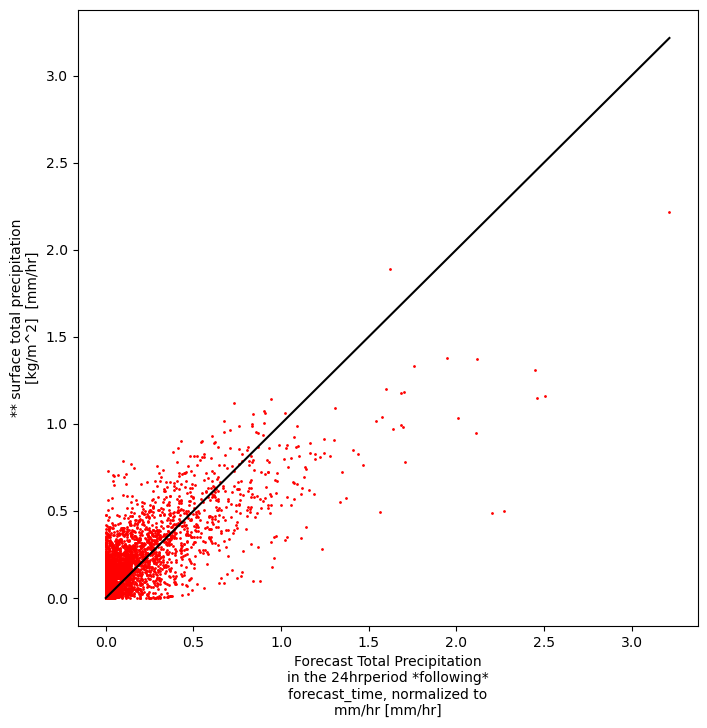

In [47]:
# Merge datasets together for plotting
plot_ds = xr.merge([GFS_input_ds, GFS_corrected_ds])

# Initiate the plot
fig, ax = plt.subplots(figsize=(8,8))

# Plot a 1:1 line
max_val = np.maximum(plot_ds.max()['pr'], plot_ds.max()['pr_corrected'])
plt.plot([0,max_val.data], [0,max_val.data], 'k-')

# Plot the data as a scatterplot
plot_ds.plot.scatter(ax=ax, x="pr_corrected", y="pr", s=4, color="red", marker=".")

## Perform Spatial Aggregation using Zonal Statistics

In this section, we will perform spatial aggregations using a basin boundary upsgream of the K.R.S Reservoir. In order to do this we must:

1. Create individual Multidimenional Raster Layers from the input netCDF files created earlier.
2. Use `Zonal Statistics as Table` to perform a multidimensional spatial aggregation.
3. Plot the resulting time-series.

#### Build a Multidimensional Raster Layer for each forecast product.

In [48]:
%%time

# Output layer name
layer_name1 = "GFS_Forecast"

# Create a Multidimensional Rater Layer in the current active Map
arcpy.md.MakeMultidimensionalRasterLayer(
    in_multidimensional_raster=GFS_daily,
    out_multidimensional_raster_layer=layer_name1,
    variables="pr",
    dimension_def="ALL",
    dimension_ranges=None,
    dimension_values=None,
    dimension="",
    start_of_first_iteration="",
    end_of_first_iteration="",
    iteration_step=None,
    iteration_unit="",
    dimensionless="DIMENSIONS",
    spatial_reference=None
)

Wall time: 420 ms


<Result 'GFS_Forecast'>

In [49]:
# Output layer name
layer_name2 = "GFS_Forecast_Bias_Corrected"

# Create a Multidimensional Rater Layer in the current active Map
arcpy.md.MakeMultidimensionalRasterLayer(
    in_multidimensional_raster=GFS_Bias_Corrected,
    out_multidimensional_raster_layer=layer_name2,
    variables='Precipitation',
    dimension_def="ALL",
    dimension_ranges=None,
    dimension_values=None,
    dimension="",
    start_of_first_iteration="",
    end_of_first_iteration="",
    iteration_step=None,
    iteration_unit="",
    dimensionless="DIMENSIONS",
    spatial_reference=None
)

<Result 'GFS_Forecast_Bias_Corrected'>

### Perform Spatial Aggregation using Zonal Statistics

In [50]:
# First, set the input layer
in_polys = os.path.join(input_data_dir, 'basins', 'KRS_Basin.shp')

In [51]:
%%time

# Define the outputs
out_table_name1 = "ZonalStats_KRS_GFS_Daily"
Out_Table1 = os.path.join(default_gdb, out_table_name1)

# Run the Zonal Statistics as Table arcpy Spatial Analyst tool
arcpy.sa.ZonalStatisticsAsTable(
    in_zone_data=in_polys,
    zone_field="BasinID",
    in_value_raster=layer_name1,
    out_table=Out_Table1,
    ignore_nodata="DATA",
    statistics_type="MEAN",
    process_as_multidimensional="ALL_SLICES",
    percentile_values=[90],
    percentile_interpolation_type="AUTO_DETECT",
    circular_calculation="ARITHMETIC",
    circular_wrap_value=360
)

Wall time: 775 ms


<geoprocessing server result object object at 0x0000024428252900>

In [52]:
%%time

# Define the outputs
out_table_name2 = "ZonalStats_KRS_GFS_Daily_Bias_Corrected"
Out_Table2 = os.path.join(default_gdb, out_table_name2)

# Run the Zonal Statistics as Table arcpy Spatial Analyst tool
arcpy.sa.ZonalStatisticsAsTable(
    in_zone_data=in_polys,
    zone_field="BasinID",
    in_value_raster=layer_name2,
    out_table=Out_Table2,
    ignore_nodata="DATA",
    statistics_type="MEAN",
    process_as_multidimensional="ALL_SLICES",
    percentile_values=[90],
    percentile_interpolation_type="AUTO_DETECT",
    circular_calculation="ARITHMETIC",
    circular_wrap_value=360
)

Wall time: 733 ms


<geoprocessing server result object object at 0x0000024428252C90>

Now that the resulting tables have been added to the Contents pane, you can create charts with the table data using the graphical user interface (GUI). Or you can proceed to create plots in the notebook using the code below.

In [53]:
#List the fields you want to include.
columns1 = [f.name for f in arcpy.ListFields(Out_Table1) if f.type!="Geometry"] 
df1 = pd.DataFrame(data=arcpy.da.SearchCursor(Out_Table1, columns1), columns=columns1)
df1 = df1.set_index('StdTime')

columns2 = [f.name for f in arcpy.ListFields(Out_Table2) if f.type!="Geometry"] 
df2 = pd.DataFrame(data=arcpy.da.SearchCursor(Out_Table2, columns2), columns=columns2)
df2['StdTime'] = pd.to_datetime(df2['StdTime'])
df2 = df2.set_index('StdTime')

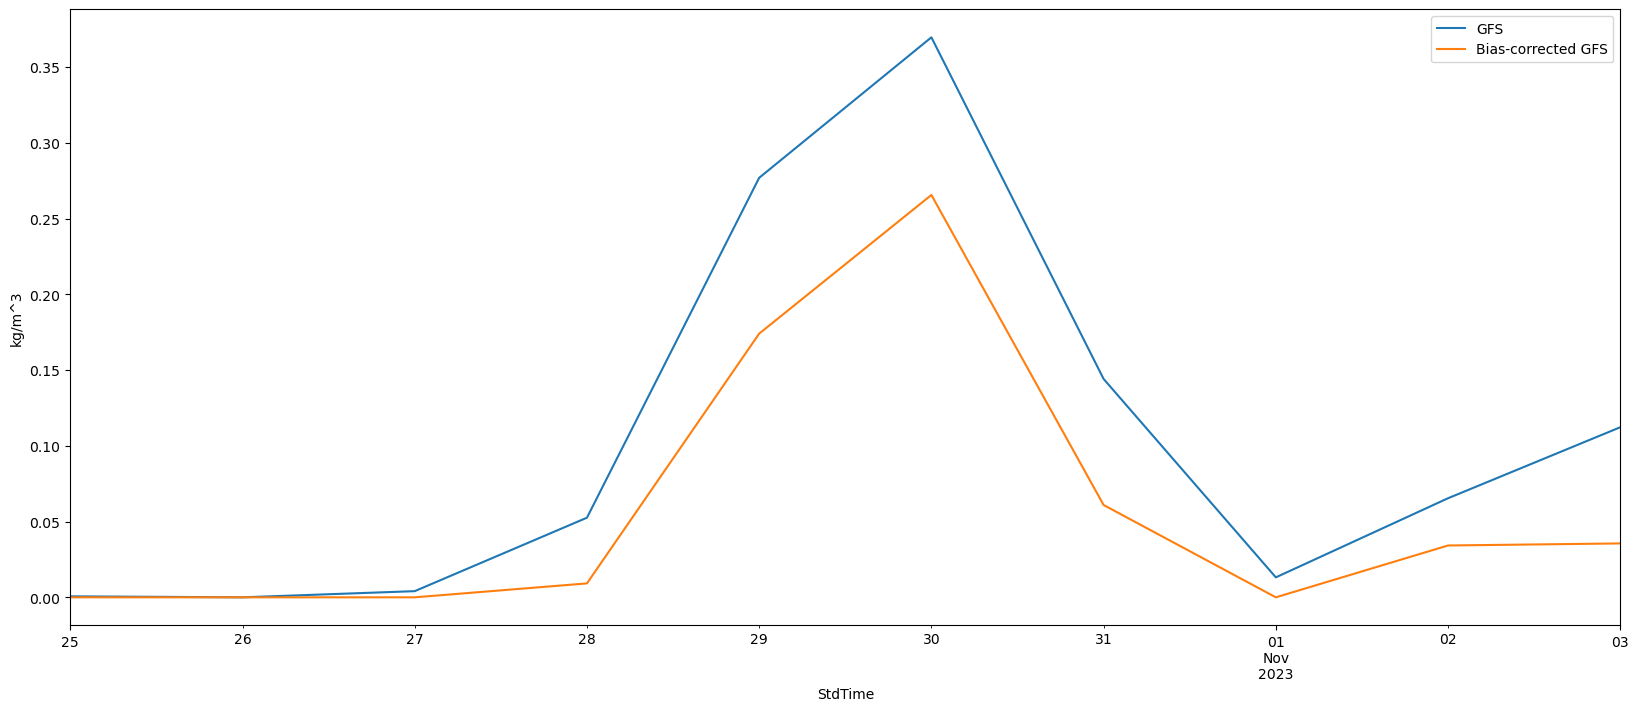

In [54]:
df1['MEAN'].plot(figsize=(20,8))
df2['MEAN'].plot(figsize=(20,8), ylabel='kg/m^3')   # Added 10/26/23
plt.legend(['GFS', 'Bias-corrected GFS'])                          # Added 10/26/23

In [55]:
# Subtact raw GFS from bias-corrected. Negative values mean bias-correction brought precip values down.
df2['MEAN'] - df1['MEAN']

StdTime
2023-10-25   -0.000651
2023-10-26    0.000000
2023-10-27   -0.004069
2023-10-28   -0.043381
2023-10-29   -0.102897
2023-10-30   -0.104104
2023-10-31   -0.083240
2023-11-01   -0.013184
2023-11-02   -0.031201
2023-11-03   -0.076712
Name: MEAN, dtype: float64

### Bring in the reservoir inflow forecast

Now tie together the precipitation forecast for the basin and the GEOGloWS reservoir inflow forecast.

In [56]:
#res_inflow_stats = os.path.join(output_data_dir, 'GeoGLOWS_Reservoir_Inflow_ensemble_stats_K_R_Sagara.csv')
res_inflow_stats = os.path.join(input_data_dir, 'geoglows', 'GeoGLOWS_Reservoir_Inflow_ensemble_stats_K_R_Sagara.csv')
res_inflow_df = pd.read_csv(res_inflow_stats)
res_inflow_df['datetime'] = pd.to_datetime(res_inflow_df['datetime'])
res_inflow_df = res_inflow_df.set_index('datetime')
res_inflow_df

,flow_max_m^3/s,flow_75%_m^3/s,flow_avg_m^3/s,flow_25%_m^3/s,flow_min_m^3/s,high_res_m^3/s
datetime,,,,,,
2023-10-18 00:00:00+00:00,108.853458,108.853458,108.853458,108.853458,108.853458,108.853458
2023-10-18 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,109.123800
2023-10-18 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,109.778525
2023-10-18 03:00:00+00:00,109.749462,109.748902,109.747517,109.748383,109.736746,110.343616
2023-10-18 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,110.827351
...,...,...,...,...,...,...
2023-11-01 00:00:00+00:00,275.928776,57.783714,59.138470,40.120805,33.970777,NaN
2023-11-01 06:00:00+00:00,251.392176,58.537418,57.979824,39.607979,34.071737,NaN
2023-11-01 12:00:00+00:00,238.286400,58.352376,57.015565,39.153686,33.824234,NaN


Setup a plot with 3 axes

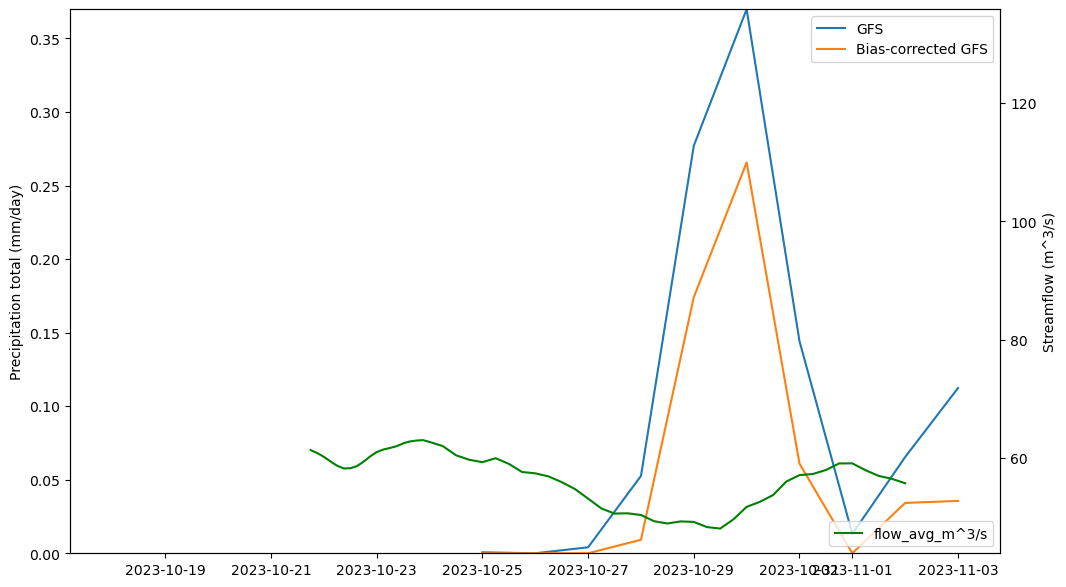

In [57]:
# Setup the plot
fig = plt.figure(figsize=(12,8))

# Plot each data series for the first axis
matplotlib.pyplot.plot(df1.index, df1['MEAN'])
matplotlib.pyplot.plot(df2.index, df2['MEAN'])

# Make some axis-level changes
ax = fig.gca()
ax.set_ylabel('Precipitation total (mm/day)')
ax.set_ylim([min(df1['MEAN'].min(), df2['MEAN'].min()), max(df1['MEAN'].max(), df2['MEAN'].max())])
ax.legend(['GFS', 'Bias-corrected GFS'])

# Add a second y-axis while sharing x-axis
ax2 = ax.twinx()
ax2.set_ylabel('Streamflow (m^3/s)')
ax2.set_frame_on(True)
ax2.patch.set_visible(False)

# Plot GEOGloWS inflows
res_inflow_df['flow_avg_m^3/s'].plot(ax=ax2, style='g-')
ax2.legend(loc='lower right')

matplotlib.pyplot.show()

### Save the project

In [58]:
aprx.save()

### Reset the namespace

The following `%reset -f` command is a built-in command in Jupyter Notebook that will reset the namespace. This is good practice to run when you are finished with the notebook.

In [ ]:
%reset -f

# Next up - Optional Lessons

This concludes the lesson.

**IT IS BEST TO EITHER SHUTDOWN THIS LESSON OR CLOSE IT BEFORE PROCEEDING TO THE NEXT LESSON TO AVOID POSSIBLY EXCEEDING ALLOCATED MEMORY. Select `Command Pallette -> restart kernel`.**

© UCAR 2023